<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/2024F/notebooks/4_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade gdown
!gdown 1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
!tar -xzf genres.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
From (redirected): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3&confirm=t&uuid=76372e6a-e05a-43f3-bb40-ac87451cdccb
To: /content/genres.tar.gz
100% 1.23G/1.23G [00:05<00:00, 226MB/s]


In [2]:
from pathlib import Path

data_dir = Path('genres')
wav_list = sorted(list(data_dir.rglob('*.wav'))) # find all wav file recursively
len(wav_list)

1000

In [3]:
import torchaudio, IPython.display as ipd

wav_fn = wav_list[520]
y, sr = torchaudio.load(wav_fn)

# resample
y = torchaudio.functional.resample(y, sr, 16000)  # waveform, orig_freq, new_freq

ipd.display(ipd.Audio(y, rate=16000)), wav_fn.parent.name

(None, 'jazz')

In [ ]:
y[:, :1000]

In [4]:
sr

22050

In [4]:
wav_fn.parent.name

'blues'

# Audio pre-processing
- Waveform (wave sample)
  - sample_value [num_ch x num_samples], samplig_rate [int]
  - mp3 파일을 열 경우에는 wav 파일의 내용과 같도록 다시 디코딩 됨
    - 때문에 mp3를 여는 것은 wav파일을 여는 것보다 훨씬 오래걸림
- Spectrogram
  - time-domain의 waveform을 frequency-domain으로 옮긴다
  - Waveform -> stft -> Spectrogram
  - Spectrogram -> x mel_filter -> Mel-spectrogram
  - Spectrogram or Mel-spectrogram -> log -> dB Spectrogram

In [8]:
import torch.nn as nn

class SpecConverter(nn.Module):
  def __init__(self,
               sample_rate=16000,
               n_fft=1024,
               hop_length=512,
               f_min=20,
               n_mels=80):

    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                        n_fft=n_fft,
                                                        hop_length=hop_length,
                                                        f_min=f_min,
                                                        n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    mel = self.mel_converter(x)
    db_mel = self.db_converter(mel) / 100
    return db_mel

spec_converter = SpecConverter()

sliced_y = y[:, 10 * 16000: 20 * 16000]

spec = spec_converter(sliced_y)


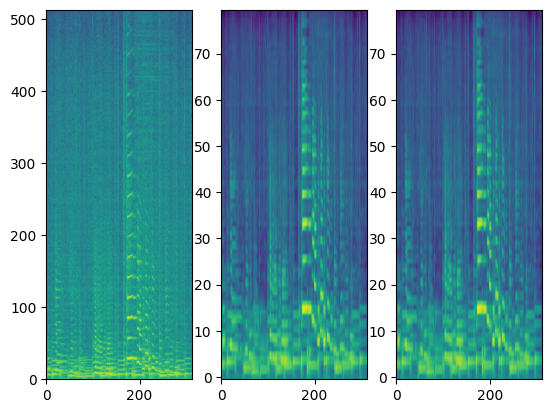

In [21]:
import matplotlib.pyplot as plt
spectrogram = torchaudio.transforms.Spectrogram(n_fft=1024)(sliced_y[0])
mel_spectrogram = torchaudio.transforms.MelScale(n_mels=80, sample_rate=16000, n_stft=513)(spectrogram)
db_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

plt.subplot(1,3,1)
plt.imshow(spectrogram.log(), origin='lower', aspect='auto')
plt.subplot(1,3,2)
plt.imshow(mel_spectrogram.log(), origin='lower', aspect='auto')
plt.subplot(1,3,3)
plt.imshow(db_spectrogram, origin='lower', aspect='auto')

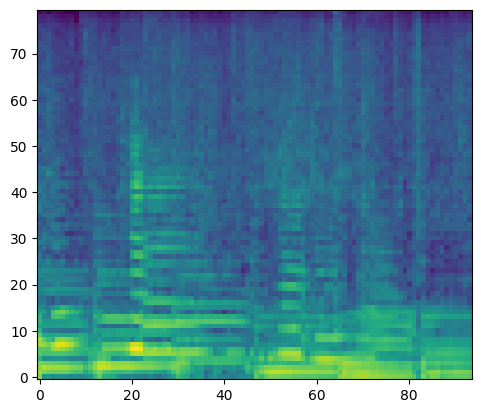

In [24]:
spec_converter = SpecConverter()
sliced_y = y[:, 10 * 16000: 13 * 16000]
spec = spec_converter(sliced_y)

plt.imshow(spec[0], origin='lower')

In [25]:
print(spec.shape)
ipd.Audio(sliced_y, rate=16000)

torch.Size([1, 80, 94])


- Input: $\mathbb{R}^{7520}$ (or $\mathbb{R}^{80 \times 94})$
- Output: $\mathbb{R}^{10}$

In [28]:
class Classifier(nn.Module):
  def __init__(self,
               input_dim = 7520,
               hidden_dim = 128,
               output_dim = 10
               ):
    super().__init__()
    self.converter = SpecConverter()
    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, audio):
    # audio.shape: N x T
    spec = self.converter(audio) # N x F x T
    spec = spec.flatten(-2) # N x (F x T)
    # print(spec.shape)
    x = self.layer1(spec) # N x
    x = x.relu()
    x = self.layer2(x) # N x H
    x = x.relu()
    x = self.layer3(x) # N x 10
    return x

model = Classifier()
out = model(sliced_y)
out.shape, out
prob = out.softmax(dim=-1)
prob

tensor([[0.1014, 0.1017, 0.0977, 0.1007, 0.0943, 0.0933, 0.0998, 0.1062, 0.1008,
         0.1040]], grad_fn=<SoftmaxBackward0>)

In [29]:
from tqdm.auto import tqdm
idx = 520

stacked_y = []
for idx in tqdm(range(0, 1000, 10)):
  wav_fn = wav_list[idx]
  y, sr = torchaudio.load(wav_fn)
  # resample
  y = torchaudio.functional.resample(y, sr, 16000)  # waveform, orig_freq, new_freq
  sliced_y = y[:, 10 * 16000: 13 * 16000]
  stacked_y.append(sliced_y)



  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
import time

model.to('cuda') # move model to gpu
# move model's parameter to gpu

start_time = time.time()
for sliced_y in stacked_y:
  out = model(sliced_y.cuda())
end_time = time.time()
print(end_time - start_time)

0.0727989673614502


In [31]:
stacked_y[0].shape

torch.Size([1, 48000])

In [39]:
import torch
# convert list of tensor to a tensor
# torch.cat은 존재하는 디멘션으로 이어붙임
# torch.stack은 존재하지 않는 새로운 디멘션을 만들어서 이어붙임
batch_y = torch.cat(stacked_y, dim=0)
batch_y.shape

start_time = time.time()
out = model(batch_y.cuda())
end_time = time.time()
print(end_time - start_time)

0.0053637027740478516


In [70]:
# Dataset Class
class Dataset:
  def __init__(self, data_dir, target_sr=16000, slice_len=3):
    self.dir = Path(data_dir)
    self.wav_fns = sorted(list(self.dir.rglob('*.wav')))
    self.target_sr = target_sr

    self.genre_names = sorted(list(set([wav_fn.parent.name for wav_fn in self.wav_fns])))
    self.gen2idx = {name:i for i, name in enumerate(self.genre_names)}
    self.slice_len = slice_len
    self.pre_loaded_wvs = self.load_audio()

  def load_audio(self):
    wavs = []

    for idx in tqdm(range(len(self))):
      wav_fn = self.wav_fns[idx]
      genre_name = wav_fn.parent.name

      y, sr = torchaudio.load(wav_fn)
      y = torchaudio.functional.resample(y, sr, 16000)
      wavs.append(y)
    return wavs

  def __len__(self):
    # how many data sample exists in the dataset
    return len(self.wav_fns)

  def __getitem__(self, idx):
    # this function is called when we call dataset[idx]
    wav_fn = self.wav_fns[idx]
    genre_name = wav_fn.parent.name

    y, sr = torchaudio.load(wav_fn)
    y = torchaudio.functional.resample(y, sr, 16000)

    # genre_idx = self.genre_names.index(genre_name)
    genre_idx = self.gen2idx[genre_name]

    return y[:, :self.slice_len * self.target_sr], genre_idx

dataset = Dataset('genres/')
dataset[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

(tensor([[ 0.0080,  0.0147, -0.0015,  ...,  0.0144, -0.0507, -0.0492]]), 0)

In [48]:
print(dataset.gen2idx)
for i, name in enumerate(dataset.genre_names):
  print(i, name)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
0 blues
1 classical
2 country
3 disco
4 hiphop
5 jazz
6 metal
7 pop
8 reggae
9 rock


In [56]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [800, 100, 100])

In [57]:
# torch dataloader
train_loader = torch.utils.data.DataLoader(train_set,
                            batch_size = 32,
                            shuffle = True,
                            drop_last=True)

for batch in train_loader:
  audio, label = batch
  print(audio.shape, label.shape)
  break


torch.Size([32, 1, 48000]) torch.Size([32])


In [67]:
# training loop
device = 'cuda'
train_loader = torch.utils.data.DataLoader(train_set,
                            batch_size = 32,
                            shuffle = True,
                            drop_last=True)

model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 0.001

model.to(device)
loss_record = []
for epoch in range(10):
  for batch in tqdm(train_loader):
    audio, label = batch
    audio = audio[:,0].to(device)
    logit = model(audio)
    prob = logit.softmax(dim=-1)
    prob_of_correct_class = prob[torch.arange(len(label)), label]
    nll = -torch.log(prob_of_correct_class + 1e-8)
    loss = nll.mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

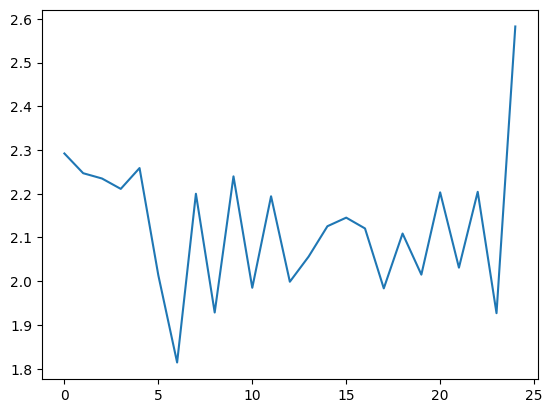

In [69]:
plt.plot(loss_record)

In [68]:
start_time = time.time()
for batch in tqdm(train_loader):
  print(1)
end_time = time.time()
print(end_time - start_time)

  0%|          | 0/25 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
19.235016107559204


In [62]:
prob.shape, label.shape

(torch.Size([32, 10]), torch.Size([32]))

In [65]:
print(prob[:,:8])

tensor([[0.0968, 0.1048, 0.0979, 0.1033, 0.0935, 0.1032, 0.0924, 0.0964],
        [0.0985, 0.1054, 0.0982, 0.1035, 0.0932, 0.1014, 0.0926, 0.0956],
        [0.0956, 0.1032, 0.1008, 0.1010, 0.0963, 0.1041, 0.0916, 0.0947],
        [0.0960, 0.1039, 0.1004, 0.1030, 0.0949, 0.1010, 0.0920, 0.0952],
        [0.0965, 0.1045, 0.0986, 0.1030, 0.0938, 0.1030, 0.0918, 0.0966],
        [0.0969, 0.1053, 0.0992, 0.1032, 0.0930, 0.1016, 0.0923, 0.0960],
        [0.0983, 0.1056, 0.0975, 0.1040, 0.0936, 0.1020, 0.0908, 0.0961],
        [0.0964, 0.1047, 0.0988, 0.1036, 0.0932, 0.1024, 0.0920, 0.0960],
        [0.0955, 0.1027, 0.0998, 0.1030, 0.0939, 0.1032, 0.0925, 0.0968],
        [0.0971, 0.1030, 0.0989, 0.1011, 0.0936, 0.1032, 0.0913, 0.0986],
        [0.0977, 0.1061, 0.0970, 0.1035, 0.0942, 0.1017, 0.0916, 0.0967],
        [0.0973, 0.1040, 0.0974, 0.1037, 0.0939, 0.1033, 0.0924, 0.0967],
        [0.0983, 0.1037, 0.0973, 0.1030, 0.0940, 0.1029, 0.0931, 0.0972],
        [0.0979, 0.1053, 0.0980, 0.104